## Lithology Prediction Using Deep Learning: Force 2020 Competition Dataset
[Ryan A. Mardani](https://www.linkedin.com/in/amardani/)

The objective of this competition was to predict lithology labels from well logs, provided NDP lithostratigraphy and well X, Y position. In this work, it is attempted to have a standard approach, like other Machine Learning problems, to improve prediction scores using Deep Learning methodology.<br> The dimension of the dataset is pretty large and for training purposes, we should consider calculation costs limitations. To tackle this problem, we can get benefit from the parallel calculation in GPU using the TensorFlow library. As we will build an almost large neural network (several hidden dense layers ), GPU calculation can speed up the training process at least ten times than CPU training mode. But, before doing anything, we need to get familiar with the dataset. You can access the full data download link from here. For detailed data explanation, you may read more from here.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import lasio 
import os
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import tensorflow as tf 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
def las_df():
    path = "./force_wells_las/"                   #path las files located
    las_files = os.listdir(path)
          
    las_list= []
          
    for i in las_files:
        if i.lower().endswith('.las'):
            las_list.append(path+i)

    df_list = []
    for i in las_list:
        las = lasio.read(i)
        df_las = las.df()
    
#         df_las['WELL'] = las.well.WELL.value # trying this ways gives some names wrong, use file name as well name
        df_las['WELL'] = i[18:-4:] # remove extra
        df_las['DEPTH'] = df_las.index
        df_list.append(df_las)          
    
    df_all = pd.concat(df_list, sort=True)
    df_all['WELL'] = df_all['WELL'].str.replace('_', '/')
    return df_all

In [3]:
df_all = las_df()

In [4]:
#According to contest
test_wells = ['15/9-14', '25/10-10', '25/11-24', '25/5-3', '29/3-1',
       '34/10-16 R', '34/3-3 A', '34/6-1 S', '35/6-2 S', '35/9-8']

blind_wells = ['15/9-23','16/2-7', '16/7-6', '17/4-1', '25/10-9',
               '31/2-10', '31/2-21 S', '34/3-2 S', '35/11-5', '35/9-7']

all_wells_list = df_all.WELL.unique()

train_wells = [i for i in all_wells_list if i not in test_wells and i not in blind_wells ]

In [5]:
#define individual datasets
df_train = df_all[df_all["WELL"].isin(train_wells)]
df_test = df_all[df_all["WELL"].isin(test_wells)]
df_blind = df_all[df_all["WELL"].isin(blind_wells)]

##### Formation tops 

In [6]:
#orignal data is xlxc format, removed unwanted columns and saved csv
well_tops = pd.read_csv('formations.csv')
well_tops.drop(columns=['Surface','X','Y','Z','Interpreter'], inplace=True)
tops = well_tops.rename(columns={"Well identifier": "key1", "MD": "key2", "HorizonName": "FORMATION"})

In [7]:
# like SQL join function, let's define a foreign keys: the first key is well name and the second measure Depth
df_all['key1'] = df_all.WELL
df_all['key2'] = df_all.DEPTH.round()# given formation denpth are round values

In [8]:
merged_df = pd.merge(df_all, tops, how = 'left', on=["key1", "key2"])

In [9]:
#keep single top for plotting aim: for that specific formation zone, we keep single formation top value in
# dataset
merged_df['FORMATION_TOPS']= merged_df.FORMATION.loc[merged_df.FORMATION.shift()!= merged_df.FORMATION]

In [10]:
lithology_labels =   {  30000: 'Sand',        
                        65030: 'Sand/Shale',  
                        65000: 'Shale',       
                        80000: 'Marl',        
                        74000: 'Dolo',        
                        70000: 'Lime',        
                        70032: 'Chak',        
                        88000: 'Halit',       
                        86000: 'Anhy',        
                        99000: 'Tuff',        
                        90000: 'Coal',        
                        93000: 'Base'  }

In [11]:
lithology_numbers =   { 30000:   0 ,  
                        65030:   1 , 
                        65000:   2 , 
                        80000:   3 , 
                        74000:   4 , 
                        70000:   5 , 
                        70032:   6 , 
                        88000:   7 , 
                        86000:   8 , 
                        99000:   9, 
                        90000:   10, 
                        93000:   11}

In [12]:
lithology_colors  =   { 30000:    '#FFFF00',
                        65030:    '#9ACD32',
                        65000:    '#228B22',
                        80000:    '#C0C0C0',
                        74000:    '#800080',
                        70000:    '#6495ED',
                        70032:    '#AFEEEE',
                        88000:    '#FFE4B5',
                        86000:    '#D2691E',
                        99000:    '#FF69B4',
                        90000:    '#191970',
                        93000:    '#800000'  }

In [13]:
lith_num =          {  'Sand'      :   0 , 
                       'Sand/Shale':   1 ,
                       'Shale'     :   2 ,
                       'Marl'      :   3 ,
                       'Dolo'      :   4 ,
                       'Lime'      :   5 ,
                       'Chak'      :   6 ,
                       'Halit'     :   7 ,
                       'Anhy'      :   8 ,
                       'Tuff'      :   9,
                       'Coal'      :   10,
                       'Base'      :   11   }

In [14]:
#map lithology name and numbers as a new column in dataset
merged_df['lithology_name'] = merged_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_labels)
merged_df['lithology_num'] = merged_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_numbers)

### 1- Data Visualization
Let's look at the data for better understanding it.

#### Geographical well distribution

##### Create location file

In [15]:
# for location X,Y coordinate, we can use those in dataset as well head position(almost all wells are vertical)
well_names_uniq = merged_df.WELL.unique()
X_cor = merged_df.groupby(['WELL'])['X_LOC'].mean()  #location coordinate 
Y_cor = merged_df.groupby(['WELL'])['Y_LOC'].mean()
data_count = merged_df.groupby(['WELL']).count().sum(axis='columns')

loc_wells_df = pd.DataFrame({'WELL':well_names_uniq, 'X_LOC': X_cor, 'Y_LOC': Y_cor, 'data_points': data_count})

In [16]:
loc_wells_df_tr = loc_wells_df[loc_wells_df["WELL"].isin(train_wells)].copy()
loc_wells_df_ts = loc_wells_df[loc_wells_df["WELL"].isin(test_wells)].copy()
loc_wells_df_bl = loc_wells_df[loc_wells_df["WELL"].isin(blind_wells)].copy()
loc_wells_df_tr['well_type']='train_wells'
loc_wells_df_ts['well_type']='test_wells'
loc_wells_df_bl['well_type']='blind_wells'
loc_wells_dfs = pd.concat([loc_wells_df_tr,loc_wells_df_ts,loc_wells_df_bl])

In [17]:
loc_wells_dfs.well_type.unique()

array(['train_wells', 'test_wells', 'blind_wells'], dtype=object)

##### Plot MAP

In [18]:
xx = loc_wells_dfs.X_LOC
yy = loc_wells_dfs.Y_LOC
ss = loc_wells_dfs.data_points
ind = loc_wells_dfs.index
cc = loc_wells_dfs.well_type

def mapPlot():
    fig, ax = plt.subplots(figsize=(18,10))

    sns.scatterplot(data=loc_wells_dfs, x=xx, y=yy, hue='well_type',size=ss, alpha=.7,
                 palette=['red', 'blue', 'green'],sizes=(10, 300), ax=ax)

    ax.set_title('Well Distributions: circle size based on data availability', fontsize = '16')
    ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
    ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

    for x,y,z in zip(xx,yy,ind):
        label_s = "{}".format(z)
        ax.annotate(label_s, (x,y),  textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize = '8') 

    ax.grid(True, color='0.6',axis='both', dashes=(5,2,1,2))
#     plt.savefig('Fig1_well_map.png', dpi=300)


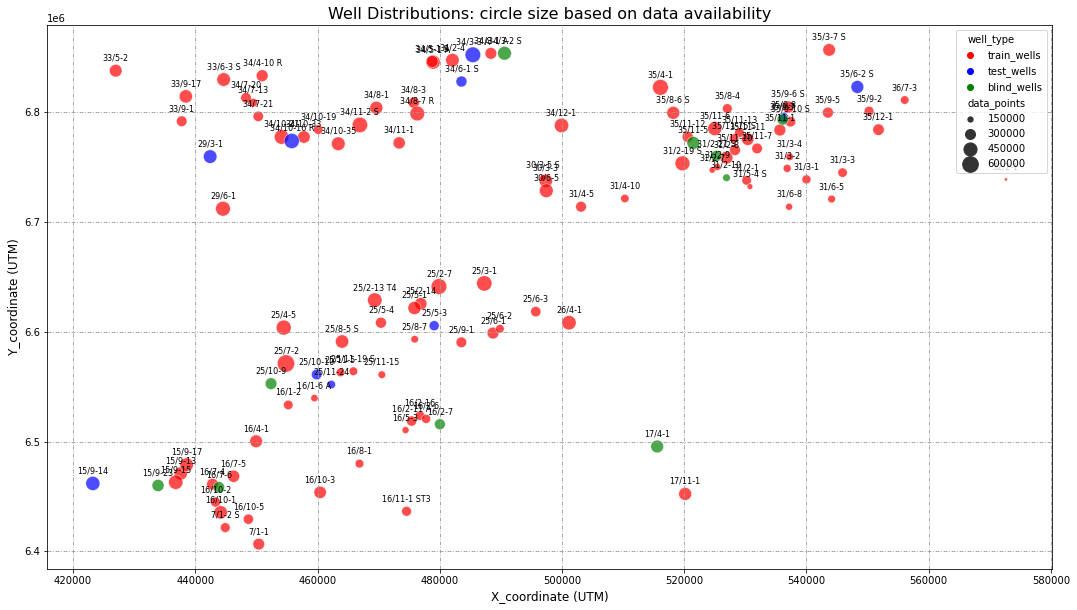

In [19]:
mapPlot()

##### Plot Log


In [20]:
def log_plots(well_x, start_depth, stop_depth):
    
    fig = plt.figure(figsize=(18,10))
    gs1 = GridSpec(1, 11, left=0.05, right=0.95, hspace=0.05,wspace=0.12, 
                   width_ratios=[.3,.4,.6, 1.1 ,1.1, 1.1, 1.1, .7, .8, .3,.45])
    
    ax0   = fig.add_subplot(gs1[0,0])
    ax1   = fig.add_subplot(gs1[0,1], sharey=ax0)
    ax2   = fig.add_subplot(gs1[0,2], sharey=ax0)
    ax3   = ax2.twiny()
    ax4   = fig.add_subplot(gs1[0,3], sharey=ax0)
    ax5   = ax4.twiny()
    ax6   = fig.add_subplot(gs1[0,4],sharey=ax0)
    ax7   = ax6.twiny()
    ax8   = ax6.twiny()
    ax9   = fig.add_subplot(gs1[0,5],sharey=ax0)
    ax10  = ax9.twiny()
    ax11  = fig.add_subplot(gs1[0,6],sharey=ax0)
    ax12  = ax11.twiny()
    ax13  = ax12.twiny()
    ax14  = fig.add_subplot(gs1[0,7],sharey=ax0)
    ax15  = ax14.twiny()
    ax16  = fig.add_subplot(gs1[0,8],sharey=ax0)
    ax17  = fig.add_subplot(gs1[0,9],sharey=ax0)
    ax18  = fig.add_subplot(gs1[0,10])
    
    
    ax_list = [ ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17 , ax18 ]
    track_list = [ ax2,ax4, ax6, ax9,  ax11,  ax14,ax16, ax17 ]
    
    for ax in ax_list:
        plt.setp(ax.get_yticklabels(), visible = False)

    ######################################################################## track0: depth
    ax0.plot(np.zeros(len(well_x['DEPTH_MD'])), well_x['DEPTH_MD'], color='k', alpha=.1, lw=1, ls= '-')
    ax0.tick_params(axis="y",direction="in", pad=-38)
    ax0.set_xlabel('MD(m)', fontsize = '12' )
    ax0.xaxis.set_label_position("top")
    ax0.set_xticklabels('')
    ax0.tick_params(axis='y', colors="lightyellow", labelsize=13 )
#     ax0.axes.yaxis.set_ticks([])
    ax0.set_facecolor('k')
    ax0.set_xticks([0, 1])

    ######################################################################## track1: formation tops

    form_top = dict(well_x[[ 'FORMATION_TOPS','DEPTH']].dropna().values.tolist())

    ax1.set_xlabel('Tops ', fontsize = '12' )
#     ax1.set_ylabel('measured depth(m) ', fontsize = '12' )
    ax1.set_xticklabels('')
    ax1.set_facecolor('#ffffed')
    ax1.set_ylim(start_depth, stop_depth)
    ax1.xaxis.set_label_position("top")
    ax1.invert_yaxis()
    for Top in form_top.values() :
        ax1.axhline( y = float(Top), color = 'k', lw = 1, ls = '-',    
                            alpha = 0.9, xmin = 0.06, xmax = 0.95 )
    for Top, MD in form_top.items():
        ax1.text( x = 0.45,  y = float(MD), s = Top,fontsize = '9', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
    ######################################################################## track2: Caliper/BS    
    ax2.plot(well_x['CALI'], well_x['DEPTH_MD'], color='r', alpha=.8, lw=0.5, ls= '-')
    ax2.set_xlabel("Caliper")
    ax2.xaxis.label.set_color("r")
    ax2.set_xlim(0, 30)
    ax2.tick_params(axis='x', colors="r")
    ax2.spines["top"].set_edgecolor("r")
    ax2.spines["top"].set_position(("axes", 1.0))
    ax2.title.set_color('r')
    ax2.fill_betweenx(well_x['DEPTH_MD'], well_x['BS'], well_x['CALI'], where=well_x['BS'] <= well_x['CALI'], 
                      facecolor='r',alpha=.5)
    ax2.set_xticks([0,10,20, 30])
    
    ax3.plot(well_x['BS'], well_x['DEPTH_MD'], color='b', alpha=.8, lw=1, ls= '-')
    ax3.set_xlabel("Bit Size")
    ax3.xaxis.label.set_color("b")
    ax3.set_xlim(0, 30)
    ax3.tick_params(axis='x', colors="b")
    ax3.spines["top"].set_edgecolor("b")
    ax3.spines["top"].set_position(("axes", 1.08))
    ax3.title.set_color('b')
    ax3.set_xticks([0,10,20,30])
    
    ############################################################################ track3: GR/SP  
    ax4.plot(well_x['GR'], well_x['DEPTH_MD'], color='g', alpha=.6, lw=0.4, ls= '-')
    ax4.set_xlabel("Gamma Ray")
    ax4.fill_betweenx(well_x['DEPTH_MD'], well_x['GR'],0,facecolor='g',alpha=.4)
    ax4.xaxis.label.set_color("g")
    ax4.set_xlim(0, 250)
    ax4.tick_params(axis='x', colors="g")
    ax4.spines["top"].set_edgecolor("g")
    ax4.spines["top"].set_position(("axes", 1.0))
    ax4.title.set_color('r')
    ax4.set_xticks([0, 50, 100, 150, 200, 250])

    ax5.plot(well_x['SP'], well_x['DEPTH_MD'], color='m', alpha=.5, lw=0.4, ls= '-')
    ax5.set_xlabel("SP")
    ax5.xaxis.label.set_color("m")
    ax5.set_xlim(0, 200)
    ax5.tick_params(axis='x', colors="m")
    ax5.spines["top"].set_edgecolor("m")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.title.set_color('m')
    ax5.set_xticks([0, 50, 100, 150, 200])

    ############################################################################ track4: Resistivity 
    ax6.plot(well_x['RDEP'], well_x['DEPTH_MD'], color='k', alpha=.8, lw=0.4, ls= '-')
    ax6.set_xlabel("Deep Res.")
    ax6.xaxis.label.set_color("k")
    ax6.tick_params(axis='x', colors="k")
    ax6.spines["top"].set_edgecolor("k")
    ax6.spines["top"].set_position(("axes", 1.0))
    ax6.title.set_color('r')
      
    ax7.plot(well_x['RMED'], well_x['DEPTH_MD'], color='r', alpha=.8, lw=0.4, ls= '-')
    ax7.set_xlabel("Medium Res.")
    ax7.xaxis.label.set_color("r")
    ax7.tick_params(axis='x', colors="r")
    ax7.spines["top"].set_edgecolor("r")
    ax7.spines["top"].set_position(("axes", 1.08))
    ax7.title.set_color('r')

    ax8.plot(well_x['RSHA'], well_x['DEPTH_MD'], color='b', alpha=.5, lw=0.4, ls= '-')
    ax8.set_xlabel("Shallow Res.")
    ax8.xaxis.label.set_color("b")
    ax8.tick_params(axis='x', colors="b")
    ax8.spines["top"].set_edgecolor("b")
    ax8.spines["top"].set_position(("axes", 1.16))
    ax8.title.set_color('r')
   
    ############################################################################ track5: Neutron-Density 
    ax9.plot(well_x['RHOB'], well_x['DEPTH_MD'], color='r', alpha=.5, lw=0.4, ls= '-')
    ax9.set_xlabel("RHOB")
    ax9.xaxis.label.set_color("r")
    ax9.tick_params(axis='x', colors="r")
    ax9.spines["top"].set_edgecolor("r")
    ax9.spines["top"].set_position(("axes", 1.0))
    ax9.title.set_color('r')
    ax9.set_xlim(1.65, 2.95)
    ax9.set_xticks([1.65, 2,  2.4,   2.8])
    
    ax10.plot(well_x['NPHI'], well_x['DEPTH_MD'], color='b', alpha=.5, lw=0.4, ls= '-')
    ax10.set_xlabel("NPHI")
    ax10.xaxis.label.set_color("b")
    ax10.tick_params(axis='x', colors="b")
    ax10.spines["top"].set_edgecolor("b")
    ax10.spines["top"].set_position(("axes", 1.08))
    ax10.title.set_color('r')
    ax10.set_xlim(.61, -.15)
    ax10.set_xticks([.6, .40, .2,  0, -.2])
    
    ############################################################################ track6: Sonic/PEF
    ax11.plot(well_x['DTC'], well_x['DEPTH_MD'], color='k', alpha=.8, lw=0.4, ls= '-')
    ax11.set_xlabel("DTC")
    ax11.xaxis.label.set_color("k")
    ax11.tick_params(axis='x', colors="k")
    ax11.spines["top"].set_edgecolor("k")
    ax11.spines["top"].set_position(("axes", 1.0))
    ax11.title.set_color('k')
    ax11.set_xlim(250, 30)
    
    ax12.plot(well_x['DTS'], well_x['DEPTH_MD'], color='b', alpha=.5, lw=0.4, ls= '-')
    ax12.set_xlabel("DTS")
    ax12.xaxis.label.set_color("b")
    ax12.tick_params(axis='x', colors="b")
    ax12.spines["top"].set_edgecolor("b")
    ax12.spines["top"].set_position(("axes", 1.08))
    ax12.title.set_color('b')
    ax12.set_xlim(450, 60)
    
    ax13.plot(well_x['PEF'], well_x['DEPTH_MD'], color='m', alpha=.5, lw=0.4, ls= '-')
    ax13.set_xlabel("PEF")
    ax13.xaxis.label.set_color("m")
    ax13.tick_params(axis='x', colors="m")
    ax13.spines["top"].set_edgecolor("m")
    ax13.spines["top"].set_position(("axes", 1.16))
    ax13.title.set_color('m')
    ax13.set_xlim(-1, 60)
    ax13.set_xticks([1,  10])
    
    ############################################################################ track7: Drilling
    ax14.plot(well_x['ROP'], well_x['DEPTH_MD'], color='r', alpha=.8, lw=0.4, ls= '-')
    ax14.set_xlabel("ROP")
    ax14.xaxis.label.set_color("r")
    ax14.tick_params(axis='x', colors="r")
    ax14.spines["top"].set_edgecolor("r")
    ax14.spines["top"].set_position(("axes", 1.0))
    ax14.title.set_color('r')
    ax14.set_xlim(-10, 100)
    ax14.set_xticks([-10,  200])

    ax15.plot(well_x['MUDWEIGHT'], well_x['DEPTH_MD'], color='b', alpha=.9, lw=0.8, ls= '-')
    ax15.set_xlabel("Mud Weight")
    ax15.xaxis.label.set_color("b")
    ax15.tick_params(axis='x', colors="b")
    ax15.spines["top"].set_edgecolor("b")
    ax15.spines["top"].set_position(("axes", 1.08))
    ax15.title.set_color('r')

    ############################################################################ track8: Lithology
    ax16.plot(well_x["FORCE_2020_LITHOFACIES_LITHOLOGY"], well_x['DEPTH_MD'], color = "black", linewidth = 0.5)
    ax16.set_xlabel("Lithology",fontsize = '12' )
    ax16.set_xlim(0, 1)
    ax16.xaxis.label.set_color("black")
    ax16.tick_params(axis='x', colors="black")
    ax16.spines["top"].set_edgecolor("black")
    ax16.set_xticks([0, 1]) 

    for key in lithology_colors.keys():
        color = lithology_colors[key]   
        ax16.fill_betweenx(well_x['DEPTH_MD'], 0, well_x['FORCE_2020_LITHOFACIES_LITHOLOGY'], 
                           where=(well_x['FORCE_2020_LITHOFACIES_LITHOLOGY']==key),facecolor=color)
    
    ############################################################################ track9: Confidence
    ax17.plot(well_x['FORCE_2020_LITHOFACIES_CONFIDENCE'], well_x['DEPTH_MD'], color='k', alpha=.9, lw=0.8, ls= '-')
    ax17.set_xlabel("Intp. Conf.")
    ax17.xaxis.label.set_color("k")
    ax17.tick_params(axis='x', colors="k")
    ax17.spines["top"].set_edgecolor("k")
    ax17.spines["top"].set_position(("axes", 1.0))
    ax17.title.set_color('k')
    ax17.set_xlim(0, 4)
    ax17.set_xticks([0, 2, 4])       
        
    ############################################################################ track10: Legend
    colors = lithology_colors.values()
    y_lines = np.linspace(1, 12, 12)
    
    for y_loc, y_col in zip(y_lines, colors):
        ax18.axhline (y_loc, color= y_col , lw = 36, ls = '-',    
                            alpha = 0.9, xmin = 0.00, xmax = 1)      

    for lith, num in lith_num.items():
        ax18.text( x = 0.5,  y = int(num), s = lith, fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'center')
    ax18.invert_yaxis()
    ax18.yaxis.set_visible(False)
    ax18.set_xlabel('Legend ', fontsize = '11' )
    ax18.xaxis.set_label_position("top")
    ax18.set_xticklabels('')
    
    ################################################################### Repeatition avoid
    for ax in ax_list:
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")               
    
    for ax in track_list:
        ax.grid(True, color='0.8', dashes=(5,2,1,2))
        ax.set_facecolor('#ffffed')
        
    fig.suptitle('Well: %s'%well_x.iloc[0]['WELL'], fontsize=18, y=1.08, x=.48)
#     plt.show()
#     plt.savefig('Fig2_log_plot.png', dpi=400, bbox_inches='tight')
        

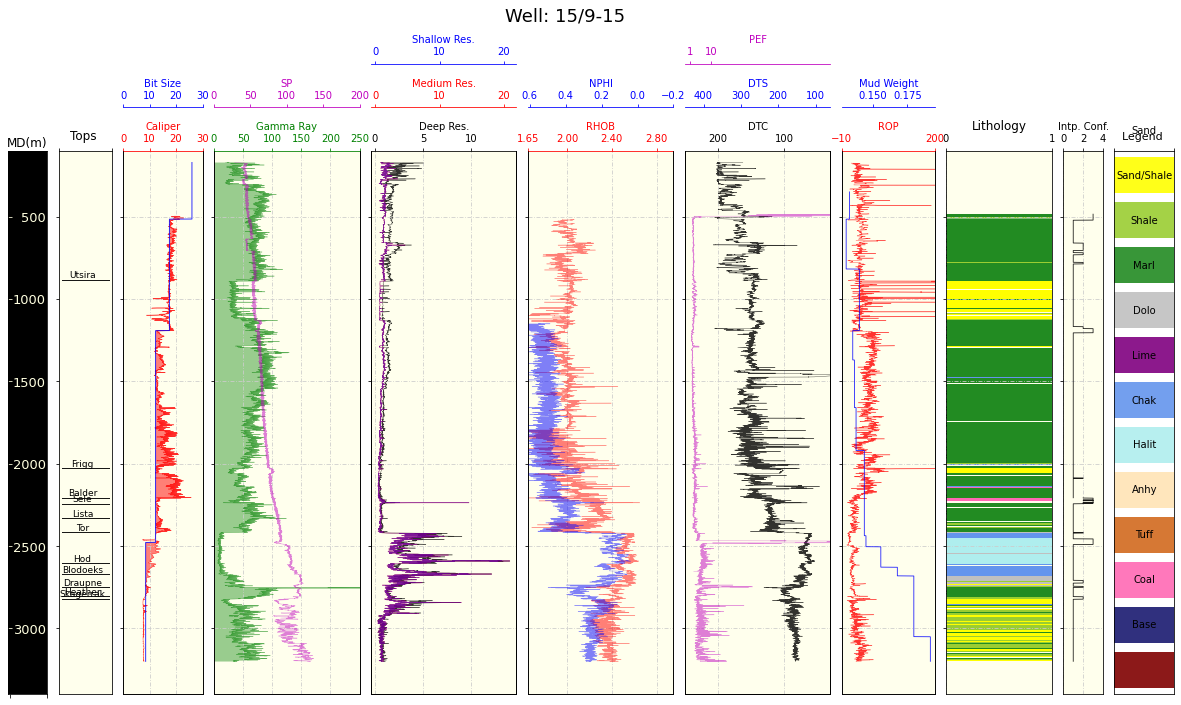

In [21]:
well_inx = 2  #change the number for another well[between 0 to 117]
well_x =  merged_df.loc[merged_df.WELL== merged_df.WELL.unique()[well_inx]]
log_plots(well_x, 100, 3400)

##### Cross Plot


In [22]:
# these are line position of dolomite, sandstone and limestone rocks for NPHI-Density standard template
sand_temp = np.array([[-0.021, 2.650],[-0.012, 2.633],[0.005, 2.594],[0.017, 2.570],[0.042, 2.520],
[0.060, 2.482],[0.105, 2.403],[0.153, 2.322],[0.202, 2.238],[0.251, 2.155],[0.303, 2.076],
[0.353, 1.994],[0.407, 1.909]])

lime_temp = np.array([[0.000, 2.71],[0.027, 2.67],[0.052,2.62],[0.100,2.54],[0.149,2.45],[0.199,2.37],
[0.251,2.28],[0.298,2.20],[0.349,2.11],[0.398,2.03],[0.445,1.95]])

dolo_temp = np.array ([[0.023,2.870],[0.039,2.865],[0.052,2.855],[0.063,2.846],[0.085,2.822],[0.119,2.778],[0.179,2.683],[0.205,2.635],
[0.228,2.590],[0.251,2.546],[0.272,2.497],[0.316,2.403],[0.333,2.363],[0.354,2.313],[0.378,2.253],[0.392,2.217],
[0.420,2.147],[0.445,2.074]])



In [23]:
def cross_plots(well_x, start_depth, stop_depth):
    
    fig = plt.figure(figsize=(12,12))
    gs1 = GridSpec(2, 2, left=0.05, right=0.95, hspace=0.2,wspace=0.2)
    
    ax1   = fig.add_subplot(gs1[0])
    ax2   = ax1.twiny()
    ax3   = ax1.twiny()
    ax4   = ax1.twiny()
        
    ax5   = fig.add_subplot(gs1[1])
    ax6   = fig.add_subplot(gs1[2])
    ax7   = fig.add_subplot(gs1[3])
     
    ########################################################################  
    well_x = well_x.loc[(well_x['DEPTH_MD'] >= start_depth) & (well_x['DEPTH_MD'] <= stop_depth)]
    
    sns.scatterplot(data=well_x, x=well_x['NPHI'], y=well_x['RHOB'], palette=lithology_colors.values(), 
                    hue = well_x['lithology_name'] , alpha=.9, ax=ax1)
    ax1.set_xlim(-0.15,1)
    ax1.set_ylim(3,1)
    ax1.text(-.08, 2.98, 'Dolomite',  rotation=40, fontsize = '7')
    ax1.text(-.10, 2.88, 'Limestone',  rotation=40, fontsize = '7')
    ax1.text(-.10, 2.75, 'Sandstone',  rotation=40, fontsize = '7')
       
    ax2.plot(sand_temp[0:, 0], sand_temp[0:, 1], color='k', alpha=.9, lw=1, ls= '-')
    ax2.set_xlim(-0.15,1)
    ax2.set_ylim(3,1)
    ax2.set_xticklabels('')
    
    ax3.plot(lime_temp[0:, 0], lime_temp[0:, 1],color='k', alpha=.9, lw=1, ls= '-')
    ax3.set_xlim(-0.15,1)
    ax3.set_ylim(3,1)
    ax3.set_xticklabels('')
    
    ax4.plot(dolo_temp[0:, 0], dolo_temp[0:, 1],color='k', alpha=.9, lw=1, ls= '-')
    ax4.set_xlim(-0.15,1)
    ax4.set_ylim(3,1)
    ax4.set_xticklabels('')
    ########################################################################  
    sns.scatterplot(data=well_x, x=well_x['NPHI'], y=well_x['DTC'], palette=lithology_colors.values(), 
                    hue = well_x['lithology_name'] , alpha=.9, ax=ax5)
    ax5.set_xlim(-0.15,1)
    ax5.set_ylim(0,200)
    ########################################################################  
    sns.scatterplot(data=well_x, x=well_x['GR'], y=well_x['RHOB'], palette=lithology_colors.values(), 
                    hue = well_x['lithology_name'] , alpha=.9, ax=ax6)
    ax6.set_xlim(0,150)
    ax6.set_ylim(3,1)
    ########################################################################      
    sns.scatterplot(data=well_x, x=well_x['NPHI'], y=well_x['GR'], palette=lithology_colors.values(), 
                    hue = well_x['lithology_name'] , alpha=.9, ax=ax7)
    ax7.set_xlim(-0.15,1)
    ax7.set_ylim(0,150)
    
    for ax in [ax1, ax5,ax6,ax7]:
        ax.grid(True, color='0.75', dashes=(5,2,1,2))
        ax.set_title('Well: %s'%well_x.iloc[0]['WELL'])
    plt.savefig('Fig3_cross_plot.png', dpi=300, bbox_inches='tight')

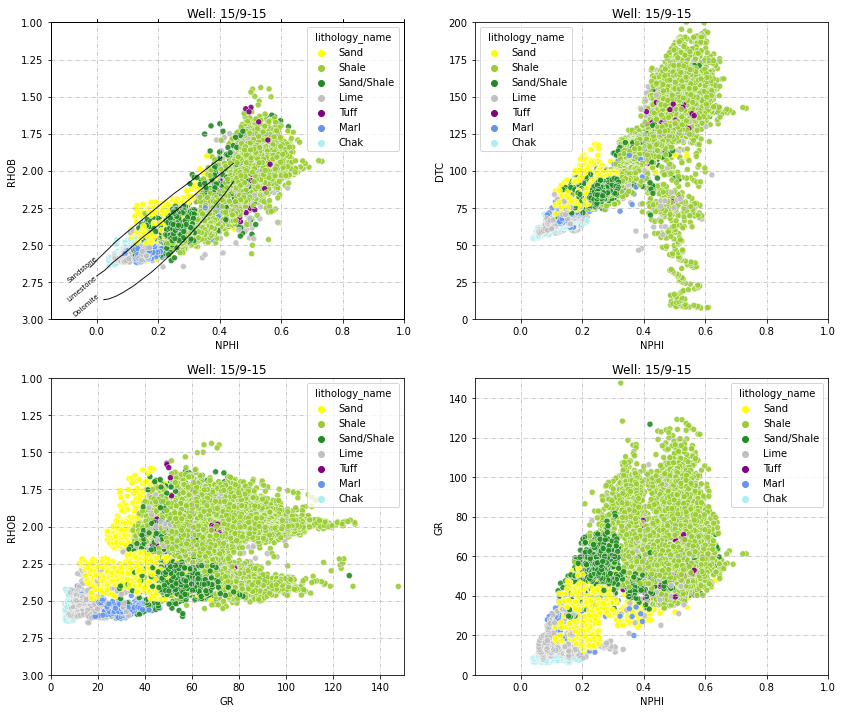

In [24]:
cross_plots(well_x,1000,3000)

####  End of Part.1

####  References:
1- https://zenodo.org/record/4351156#.YD17iWhKjUr <br>
2- [Displaying Lithology Data on a Well Log Plot Using Python](https://towardsdatascience.com/displaying-lithology-data-using-python-and-matplotlib-58b4d251ee7a)
